In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torchtext.data import get_tokenizer
from torchtext.vocab import vocab
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# Load tokens (10000 most frequent words in reviews)
filename = "../data/tokens_list_10k.csv"
tokens = pd.read_csv(filename).drop("Unnamed: 0", axis=1)
n_tokens = len(tokens)

# Store in Pandas series and index for fast checking of indices
ts = pd.Series(tokens["token"], tokens.index)
ts_i = pd.Index(ts)

In [3]:
# Build vocabulary from 10000 most frequent tokens
tokens_dict = tokens.set_index("token")["frequency"].to_dict(OrderedDict)
vocabulary = vocab(tokens_dict, specials=["<UNKNOWN>"])
vocabulary.set_default_index(vocabulary["<UNKNOWN>"])

In [4]:
# Initialize tokenizer and test vocabulary
tokenizer = get_tokenizer("basic_english")
vocabulary(tokenizer("the good game."))

[2, 26, 7, 1]

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
max_words = 25
batch_size = 10000
embedding_size = 50
learning_rate = 0.001
hidden_size = 50
num_layers = 1

In [6]:
# Function to create tensors from batch of data
def batch_to_tensors(reviews, sentiments):
    
    X = [vocabulary(tokenizer(text)) if type(text) == str else [0] * max_words for text in reviews]
    X = [tokens + ([0] * (max_words-len(tokens))) if len(tokens) < max_words else tokens[:max_words] for tokens in X]
    Y = [[s] for s in sentiments]
    return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, dtype=torch.float, device=device)

In [7]:
batch_to_tensors(["good game.", "yes true"], [1, 1])

(tensor([[ 26,   7,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [178, 631,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
        device='cuda:0', dtype=torch.int32),
 tensor([[1.],
         [1.]], device='cuda:0'))

In [8]:
# Recurrent neural network with one hidden layer
class RNN(nn.Module):

    def __init__(self, embedding_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(len(vocabulary), embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers,
                          batch_first=True, nonlinearity="relu")
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, X_batch):
        # Set initial hidden states
        h0 = torch.zeros(self.num_layers, len(X_batch), self.hidden_size).to(device)

        # Calculate embeddings
        embeddings = self.embedding(X_batch)

        # Forward propagate RNN
        output, hidden = self.rnn(embeddings, h0)

        # Decode the hidden state of the last step
        return self.linear(output[:,-1])


In [9]:
# Create model
model = RNN(embedding_size, hidden_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
model

RNN(
  (embedding): Embedding(10001, 50)
  (rnn): RNN(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [11]:
# Function for training with a single batch
def train(X, Y):

    # Do forward pass
    output = model(X)

    # Calculate loss
    loss = criterion(output, Y)

    # Reset gradients and do backward propagation
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()
    
    return output, loss.item()

In [14]:
# Read data and train model
filename = "../data/all_reviews/all_reviews_english_balanced.csv"
all_losses = []
plot_steps, print_steps = 1, 1
n_chunks = 20
n_iters = 10
with pd.read_csv(filename, chunksize=batch_size) as reader:
    for i in range(n_iters):
        c = 0
        current_loss = 0
        for chunk in reader:
            c = c + 1
            if c > n_chunks:
                break
                
            X, Y = batch_to_tensors(chunk["review"], chunk["voted_up"])
            output, loss = train(X, Y)
            current_loss += loss
    
        # Append loss for plotting
        if (i+1) % plot_steps == 0:
            all_losses.append(current_loss / n_chunks)
            current_loss = 0
    
        # Print information
        if (i+1) % print_steps == 0:
            print(f"{(i+1)/n_iters*100:2.0f} % done, loss: {loss:.4f}")


10 % done, loss: 0.7031
20 % done, loss: 0.6810
30 % done, loss: 0.6931
40 % done, loss: 0.6546
50 % done, loss: 0.6608
60 % done, loss: 0.5837
70 % done, loss: 0.5830
80 % done, loss: 0.5205
90 % done, loss: 0.5720
100 % done, loss: 0.5395


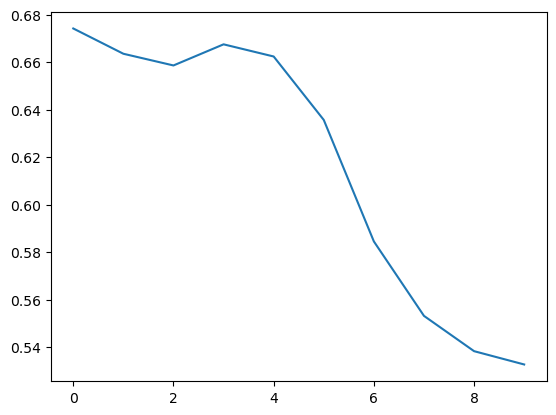

In [15]:
plt.plot(all_losses)

In [16]:
def predict(text):
    print(f"\n> {text}")
    with torch.no_grad():
        X, Y = batch_to_tensors([text], [0])
        output = model(X)
        guess = (output[0][0] >= 0.5)
        print(guess, output)

In [17]:
predict("this is a very poor game and i don't like it")


> this is a very poor game and i don't like it
tensor(False, device='cuda:0') tensor([[-0.4128]], device='cuda:0')


In [18]:
predict("this is a very good game")


> this is a very good game
tensor(True, device='cuda:0') tensor([[1.5558]], device='cuda:0')


In [19]:
predict("this game sucks")


> this game sucks
tensor(False, device='cuda:0') tensor([[-0.9280]], device='cuda:0')


In [20]:
predict("i like the characters")


> i like the characters
tensor(True, device='cuda:0') tensor([[1.5556]], device='cuda:0')


In [21]:
predict("there are too many players and it's lagging")


> there are too many players and it's lagging
tensor(False, device='cuda:0') tensor([[-0.7083]], device='cuda:0')
